In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import configs
import seaborn as sns
import pandas as pd
import h5py

In [17]:
os.listdir('/mnt/smb/locker/abbott-locker/hcnn/2_hyperp')

['pnet_cgram_shuffle',
 'pnet_pt2',
 'random_matched',
 'pnet_t4',
 'pnet_erm_ablate',
 'erm_ablation',
 'pnet_erm_uniform',
 '.DS_Store',
 'test',
 'pnet',
 'pnet_freq_shuffle_merged',
 'pnet_fbm_ablate',
 'random_kaiming',
 'pnet_merged',
 'pnet_pt3',
 'pnet_snr-9_pt2',
 'pnet_snr-9',
 'fbm_ablation']

In [18]:
exp = 'pnet_pt3'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
tensorboard_dir = f'{engram_dir}2_hyperp/{exp}/'
activations_dir = f'{engram_dir}3_activations/{exp}/'
plot_ci = True

In [35]:
merged = False

In [19]:
load_valid_scores = False

# Helper functions

In [20]:
def eval_accuracy(results, timestep=4):
    """ t is the timestep to eval """
    labels = np.array(results['label'])
    timesteps = []
    accuracies = []
    rel_accuracies = []
    ff_corrects = []
    clean_corrects = []
    n_timesteps = 5
    
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            rel_acc_t = acc_t - ff_acc
            if  t != timestep:
                continue
            timesteps.append(t)
            accuracies.append(acc_t)
            rel_accuracies.append(rel_acc_t)
            ff_corrects.append(ff_acc)
            clean_corrects.append(results['clean_correct'][i])

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    rel_accuracies = np.array(rel_accuracies)
    ff_corrects = np.array(ff_corrects)
    clean_corrects = np.array(clean_corrects)
            
    return timesteps, accuracies, rel_accuracies, ff_corrects, clean_corrects

# Collect hyperparameter values

In [36]:
feedforward = []
feedback = []
memory = []
error_scaling = []
iteration = []
bg = []
snr = []
layers = []
epochs = []
valid_scores = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    noise_info = tfdir.split('_')
    if not merged:
        noise_snr = float(noise_info[-1][3:])
        noise_bg = noise_info[1]
    else:
        noise_snr = 0.
        noise_bg = 'N/A'
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload() 
        if load_valid_scores:
            file_id = tfdir_file.split('edu.')[-1]
            activ_path = f'{activations_dir}{noise_bg}_snr{int(noise_snr)}/{file_id}.hdf5'
            activ_results = h5py.File(activ_path, 'r')
            _, _, rel_acc, _, _ = eval_accuracy(activ_results)
            #_, acc, _, _, _ = eval_accuracy(activ_results)
            score = np.mean(rel_acc)
        else:
            score = 0

        for i in range(1, 6):
            _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedforward")]
            _feedback = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedback")]
            _memory = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_memory")]
            _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_error")]
            
            feedforward.extend(_feedforward)
            feedback.extend(_feedback)
            memory.extend(_memory)
            error_scaling.extend(_error_scaling)
            layers.extend([i]*len(_feedforward))
            epochs.extend([e+1 for e in range(len(_feedforward))])
            iteration.extend([_iter]*len(_feedforward))
            bg.extend([noise_bg]*len(_feedforward))
            snr.extend([noise_snr]*len(_feedforward))
            valid_scores.extend([score]*len(_feedforward))

# Make pandas dataframe
df = pd.DataFrame({
    'Feedforward': feedforward,
    'Feedback': feedback,
    'Memory': memory,
    'Error Scaling': error_scaling,
    'Background Noise': bg,
    'SNR': snr, 
    'Layer': layers,
    'Epoch': epochs,
    'Validation Score': valid_scores
    })


In [37]:
np.unique(epochs)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [38]:
np.sum(np.array(epochs)==100)

450

In [39]:
np.sum(np.array(epochs)==2)

450

In [37]:
max_epoch = np.max(epochs)

In [40]:
max_epoch = 100

In [41]:
df = df[df['Epoch'] == max_epoch]

# As a function of SNR, collapsed across layers

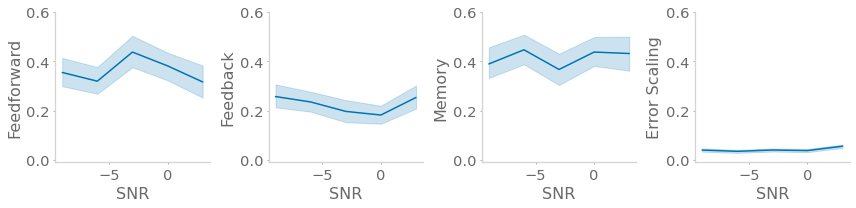

In [42]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
sns.lineplot(
    x='SNR', y='Feedforward', ax=axs[0], data=df)
sns.lineplot(
    x='SNR', y='Feedback', ax=axs[1], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Memory', ax=axs[2], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Error Scaling', ax=axs[3], data=df, legend=None)
for ax in axs:
    ax.set_ylim(-0.01, 0.6)
    #ax.axhline(0, color='blue', linestyle='--')
plt.tight_layout()
plt.show()

In [43]:
df

,Feedforward,Feedback,Memory,Error Scaling,Background Noise,SNR,Layer,Epoch,Validation Score
99,0.326693,0.347984,0.325323,0.035477,Babble8Spkr,-6.0,1,100,0
200,0.273904,0.483873,0.242223,0.071334,Babble8Spkr,-6.0,2,100,0
301,0.024357,0.400063,0.575580,0.032896,Babble8Spkr,-6.0,3,100,0
402,0.003807,0.775749,0.220444,0.054162,Babble8Spkr,-6.0,4,100,0
503,0.142575,0.000000,0.857425,0.031975,Babble8Spkr,-6.0,5,100,0
...,...,...,...,...,...,...,...,...,...
45044,0.928219,0.027141,0.044639,0.050511,pinkNoise,-3.0,1,100,0
45145,0.704138,0.231614,0.064248,0.023883,pinkNoise,-3.0,2,100,0
45246,0.604525,0.331166,0.064309,0.031914,pinkNoise,-3.0,3,100,0
45347,0.302002,0.455960,0.242038,0.049356,pinkNoise,-3.0,4,100,0


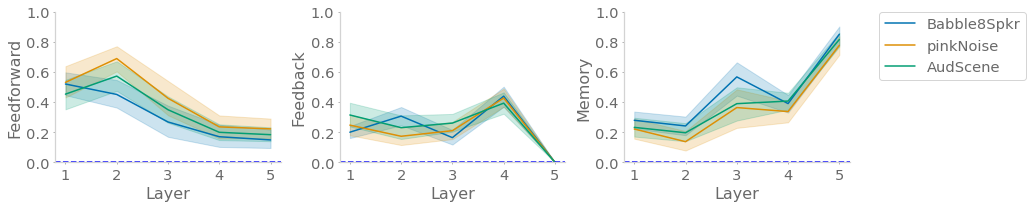

In [54]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))
sns.lineplot(
    x='Layer',hue='Background Noise', y='Feedforward', ax=axs[0], data=df, legend=None)
sns.lineplot(
    x='Layer',hue='Background Noise', y='Feedback', ax=axs[1], data=df, legend=None)
sns.lineplot(
    x='Layer',hue='Background Noise', y='Memory', ax=axs[2], data=df)
for ax in axs:
    ax.set_ylim(0.0, 1.)
    ax.axhline(0, color='blue', linestyle='--')
plt.tight_layout()
axs[2].legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# As a function of layers, collapsed across SNR/BG

In [27]:
from scipy.stats import sem

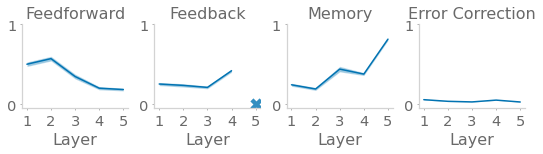

In [28]:
fig, axs = plt.subplots(1, 4, figsize = (10*0.75,3*0.75)) #12, 3
hyperparams = ['Feedforward', 'Feedback', 'Memory', 'Error Scaling']
layers = np.arange(1, 6)

for h_idx, hyperparam in enumerate(hyperparams):
    layer_x_axis = []
    layer_means = []
    layer_sems = []
    for layer in layers:
        if hyperparam == 'Feedback' and layer == 5:
            continue
        vals = df[df['Layer']==layer][hyperparam]
        layer_x_axis.append(layer)
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    axs[h_idx].plot(layer_x_axis, layer_means)
    axs[h_idx].fill_between(
        layer_x_axis, layer_means-layer_sems, layer_means+layer_sems,
        alpha=0.4
        )
    axs[h_idx].set_title(hyperparam)
    if hyperparam == 'Error Scaling':
        axs[h_idx].set_title('Error Correction')
axs[1].scatter(
    5, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)

for ax in axs:
    ax.set_ylim(-0.05, 0.8)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.0, 1.])
    ax.set_xlabel('Layer')
plt.tight_layout()
plt.savefig('hyperparameters.png', dpi=300)
plt.show()
print('\n\n')

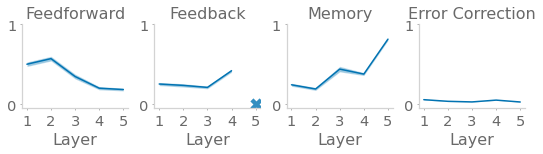

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (10*0.75,3*0.75)) #12, 3
hyperparam = 'Feedforward'
layers = np.arange(1, 6)

for h_idx, bg in enumerate():
    layer_x_axis = []
    layer_means = []
    layer_sems = []
    for layer in layers:
        if hyperparam == 'Feedback' and layer == 5:
            continue
        vals = df[df['Layer']==layer][hyperparam]
        layer_x_axis.append(layer)
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    axs[h_idx].plot(layer_x_axis, layer_means)
    axs[h_idx].fill_between(
        layer_x_axis, layer_means-layer_sems, layer_means+layer_sems,
        alpha=0.4
        )
    axs[h_idx].set_title(hyperparam)
    if hyperparam == 'Error Scaling':
        axs[h_idx].set_title('Error Correction')
axs[1].scatter(
    5, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)

for ax in axs:
    ax.set_ylim(-0.05, 0.8)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.0, 1.])
    ax.set_xlabel('Layer')
plt.tight_layout()
plt.savefig('hyperparameters.png', dpi=300)
plt.show()
print('\n\n')

# Hyperparameters, scaled by performance

In [29]:
new_df = df.copy()
for bg in np.unique(df['Background Noise']):
    for snr in np.unique(df['SNR']):
        scores = df[
            (df['Background Noise'] == bg) & (df['SNR'] == snr)
            ]['Validation Score']
        max_score = np.max(scores)
        min_score = np.min(scores)
        new_df.loc[
            (new_df['Background Noise'] == bg) & (new_df['SNR'] == snr)
            , ['Validation Score']] = (scores - min_score)/(max_score+1E-5)

ZeroDivisionError: Weights sum to zero, can't be normalized

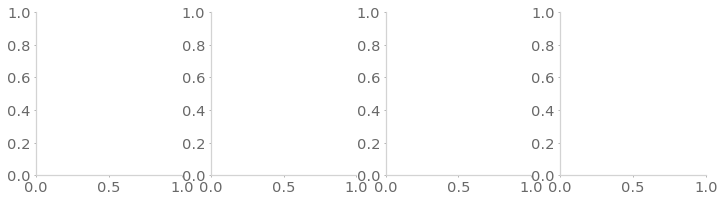

In [30]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
for hyp_idx, hyp in enumerate(['Feedforward', 'Feedback', 'Memory', 'Error Scaling']):
    layerwise_plot = []
    for layer in np.arange(1, 6):
        scores = new_df[new_df['Layer'] == layer]['Validation Score']
        hyp_vals = new_df[new_df['Layer'] == layer][hyp]
        weighted_hyp_vals = np.average(hyp_vals, weights=scores)
        if hyp == 'Feedback' and layer == 5: break
        layerwise_plot.append(weighted_hyp_vals)
    axs[hyp_idx].plot(layerwise_plot)
    axs[hyp_idx].set_title(hyp)
axs[1].scatter(4, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)
for ax in axs:
    ax.set_ylim(-0.05, 0.8)
    ax.set_xticks(np.arange(5), np.arange(5)+1)
    ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('Layer')
plt.suptitle(f'All Background Noises and SNRs', fontsize=14)
plt.tight_layout()
plt.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

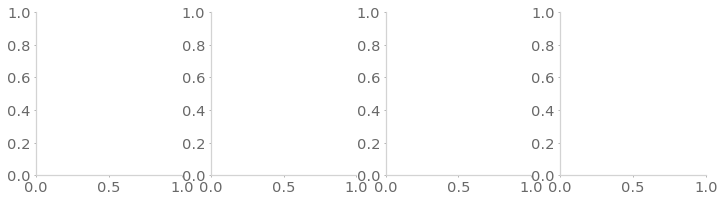

In [31]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
for hyp_idx, hyp in enumerate(['Feedforward', 'Feedback', 'Memory', 'Error Scaling']):
    layerwise_plot = []
    snr_list = [-9., -6., -3.,  0.,  3.]
    for snr in snr_list:
        scores = new_df[new_df['SNR'] == snr]['Validation Score']
        hyp_vals = new_df[new_df['SNR'] == snr][hyp]
        weighted_hyp_vals = np.average(hyp_vals, weights=scores)
        layerwise_plot.append(weighted_hyp_vals)
    axs[hyp_idx].plot(layerwise_plot)
    axs[hyp_idx].set_title(hyp)
for ax in axs:
    ax.set_ylim(-0.01, 0.5)
    ax.set_xticks(np.arange(len(snr_list)), snr_list)
    #ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('SNR')
plt.suptitle(f'All Background Noises and Layers', fontsize=14)
plt.tight_layout()
plt.show()